In [1]:
from   pathlib      import Path
import importlib

import numpy                as np
import matplotlib           as mpl
import matplotlib.pyplot    as plt
import matplotlib.patches   as mpatches
import seaborn              as sns
import pandas               as pd

from scipy.stats   import kruskal, wilcoxon, mannwhitneyu, ranksums
from scipy.optimize import curve_fit
from scipy.stats import linregress

from PIL            import Image

# from eidynamics     import utils, data_quality_checks, ephys_classes, plot_tools, expt_to_dataframe
# from eidynamics     import pattern_index
# from eidynamics     import abf_to_data
# from Findsim        import tab_presyn_patterns_LR_43
# import parse_data
from eidynamics.fit_PSC     import find_sweep_expected
from eidynamics     import utils, plot_tools
from eidynamics     import pattern_index
import all_cells
import plotFig2
import stat_annotate

# sns.set_context('paper')
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'
%matplotlib widget

# make a colour map viridis
viridis = mpl.colormaps["viridis"]
cividis = mpl.colormaps["cividis"]
flare   = mpl.colormaps["flare"]
crest   = mpl.colormaps["crest"]
magma   = mpl.colormaps["magma"]
edge    = mpl.colormaps['edge']

color_E             = "flare"
color_I             = "crest"
color_freq          = {1:magma(0.05), 5:magma(0.1), 8:magma(0.15), 10:magma(0.2), 20:magma(.4), 30:magma(.5), 40:magma(.6), 50:magma(.7), 100:magma(.9)}
color_squares       = {1:viridis(0.2), 5:viridis(.4), 7:viridis(.6), 15:viridis(.8), 20:viridis(1.0)}
color_squares_EI    = {-70: {1:flare(0.2), 5:flare(.4), 7:flare(.6), 15:flare(.8), 20:flare(1.0)}, 
                         0: {1:crest(0.2), 5:crest(.4), 7:crest(.6), 15:crest(.8), 20:crest(1.0)}}
color_EI            = {-70:flare(0.5), 0:crest(0.5)}
Fs = 2e4

freq_sweep_pulses = np.arange(9)

>> Working on:  C:\Users\adity\OneDrive\NCBS


## Load Data

In [2]:
figure_raw_material_location = Path(r"paper_figure_matter\\")
paper_figure_export_location = Path(r"paper_figures\\Figure1v4")
data_path_FS                 = Path(r"parsed_data\\FreqSweep\\")
data_path_grid               = Path(r"parsed_data\\Grid\\")
data_path_analysed           = Path(r"parsed_data\\second_order\\")
raw_data_path_cellwise       = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Data\Screened_cells\\")

## Short Dataframes containing analysed params

In [3]:
# short data path that contains the kernel fit data for FreqSweep protocol, also contains the field p2p data. latest and checked. Use this for all freqsweep measurements.
# Contains screening parameters also.
# 18Sep24
CC_FS_shortdf_withkernelfit_datapath = data_path_FS / "all_cells_FreqSweep_CC_kernelfit_response_measurements.h5"
cc_FS_shortdf = pd.read_hdf(CC_FS_shortdf_withkernelfit_datapath, key='data')
print(cc_FS_shortdf.shape)

VC_FS_shortdf_withkernelfit_datapath = data_path_FS / "all_cells_FreqSweep_VC_kernelfit_response_measurements.h5"
vc_FS_shortdf = pd.read_hdf(VC_FS_shortdf_withkernelfit_datapath, key='data')
print(vc_FS_shortdf.shape)

# short data path for all protocols.
# Does not contain kernel fit measurements and does not contain screening parameters. Only use for other protocols.
# 18Sep24
dfshortpath     = data_path_analysed / "all_cells_allprotocols_with_fpr_values.h5"
xc_all_shortdf  = pd.read_hdf(dfshortpath, key='data')
print(xc_all_shortdf.shape)

(4971, 163)
(4407, 163)
(16870, 63)


### Long Datadframes containing raw data and some analysed params

In [4]:
# Load the long dataset
cc_FS_datapath =  data_path_FS / "all_cells_FreqSweep_CC_long.h5" 
vc_FS_datapath =  data_path_FS / "all_cells_FreqSweep_VC_long.h5"

# Load it later as needed
# cc_FS_longdf = pd.read_hdf(cc_FS_datapath, key='data')
# vc_FS_longdf = pd.read_hdf(vc_FS_datapath, key='data')

### Data screening

In [5]:
# CC data screening based on dataflag_fields
cc_FS_shortdf_slice = cc_FS_shortdf[
            (cc_FS_shortdf['location'] == 'CA1') &
            (cc_FS_shortdf['numSq'].isin([1,5,15])) &
            (cc_FS_shortdf['condition'] == 'Control') &
            (cc_FS_shortdf['ch0_response']==1) &
            (cc_FS_shortdf['intensity'] == 100) &
            (cc_FS_shortdf['pulseWidth'] == 2) &
            (cc_FS_shortdf['IR'] >50) & (cc_FS_shortdf['IR'] < 300) &
            (cc_FS_shortdf['tau'] < 40) & 
            (cc_FS_shortdf['ac_noise_power_in_ch0'] < 40) &
            (cc_FS_shortdf['spike_in_baseline_period'] == 0) &
            (cc_FS_shortdf['sweepBaseline'] > -100) & (cc_FS_shortdf['sweepBaseline'] < 100)
        ]
print(cc_FS_shortdf.shape, '--screened-->', cc_FS_shortdf_slice.shape)
screened_cc_trialIDs = cc_FS_shortdf_slice['trialID'].unique()

print(f"Unique cells in screened data: { cc_FS_shortdf_slice['cellID'].nunique()}")
print(f"Unique sweeps in screened data: {cc_FS_shortdf_slice['trialID'].nunique()}")

# save the screened trialIDs
# save trial IDs as a numpy array text file, all trialID are strings
np.savetxt(paper_figure_export_location / "Figure1_screened_trialIDs_CC_FS.txt", screened_cc_trialIDs, fmt='%s')


(4971, 163) --screened--> (2470, 163)
Unique cells in screened data: 16
Unique sweeps in screened data: 2470


In [6]:
# CC data screening based on dataflag_fields
vc_FS_shortdf_slice = vc_FS_shortdf[
            (vc_FS_shortdf['location'] == 'CA1') &
            (vc_FS_shortdf['numSq'].isin([1,5,15])) &
            (vc_FS_shortdf['stimFreq'].isin([20,30,40,50])) &
            (vc_FS_shortdf['condition'] == 'Control') &
            (vc_FS_shortdf['ch0_response']==1) &
            (vc_FS_shortdf['IR'] >50) & (vc_FS_shortdf['IR'] < 300) &
            (vc_FS_shortdf['tau'] < 40) & 
            (vc_FS_shortdf['ac_noise_power_in_ch0'] < 40)
        ]
print(vc_FS_shortdf.shape, '--screened-->', vc_FS_shortdf_slice.shape)
screened_vc_trialIDs = vc_FS_shortdf_slice['trialID'].unique()

print(f"Unique cells in screened data: { vc_FS_shortdf_slice['cellID'].nunique()}")
print(f"Unique sweeps in screened data: {vc_FS_shortdf_slice['trialID'].nunique()}")

# save the screened trialIDs
# save trial IDs as a numpy array text file, all trialID are strings
np.savetxt(paper_figure_export_location / "Figure1_screened_trialIDs_VC_FS.txt", screened_vc_trialIDs, fmt='%s')

(4407, 163) --screened--> (1912, 163)
Unique cells in screened data: 14
Unique sweeps in screened data: 1912


In [7]:
# combine short dataframes slice
xc_FS_shortdf_slice = pd.concat([cc_FS_shortdf_slice, vc_FS_shortdf_slice], axis=0)

### Load the Longform data and keep the screened trials only to save space

In [8]:
# load the data
cc_FS_datapath =  data_path_FS / "all_cells_FreqSweep_CC_long.h5"
cc_FS_longdf = pd.read_hdf(cc_FS_datapath, key='data')

cc_FS_longdf_slice = cc_FS_longdf[ cc_FS_longdf['trialID'].isin(screened_cc_trialIDs) ]
print(cc_FS_longdf.shape, '--screened-->', cc_FS_longdf_slice.shape)
del cc_FS_longdf

# load the data
vc_FS_datapath =  data_path_FS / "all_cells_FreqSweep_VC_long.h5"
vc_FS_longdf = pd.read_hdf(vc_FS_datapath, key='data')

vc_FS_longdf_slice = vc_FS_longdf[ vc_FS_longdf['trialID'].isin(screened_vc_trialIDs) ]
print(vc_FS_longdf.shape, '--screened-->', vc_FS_longdf_slice.shape)
del vc_FS_longdf

xc_FS_longdf_slice = pd.concat([cc_FS_longdf_slice, vc_FS_longdf_slice])
del cc_FS_longdf_slice, vc_FS_longdf_slice

(4971, 80073) --screened--> (2470, 80073)
(4407, 80073) --screened--> (1912, 80073)


# Figure 1

Plotting all 4 signals on a single plot
[]
plotting 1 and -70
(127, 80073)
6 1 [147]
plotting 5 and -70
(15, 80073)
48 5 [197, 255, 347, 401, 439]
plotting 15 and -70
(9, 80073)
55 15 [105, 151, 163, 201, 213, 247, 259, 293, 297, 389, 397, 435, 489, 493, 501]


C:\Users\adity\AppData\Local\Temp\ipykernel_30780\2510077096.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftemp1['field_fpr_p2p'] = dftemp1['field_fpr_p2p']*0.05


(26, 163) (246, 163)
[]
plotting 1 and -70
(127, 80073)
6 1 [147]
plotting 5 and -70
(15, 80073)
48 5 [197, 255, 347, 401, 439]
plotting 15 and -70
(6, 80073)
52 15 [101, 109, 117, 147, 155, 197, 305, 309, 339, 343, 351, 401, 451, 485, 497]
[-70   0]
[]
plotting 1 and -70
(134, 80073)
plotting 1 and 0
(29, 80073)
16 1 [243]
plotting 5 and -70
(57, 80073)
plotting 5 and 0
(5, 80073)
47 5 [205, 251, 297, 389, 447]
plotting 15 and -70
(24, 80073)
plotting 15 and 0
(2, 80073)
52 15 [101, 109, 117, 147, 155, 197, 305, 309, 339, 343, 351, 401, 451, 485, 497]


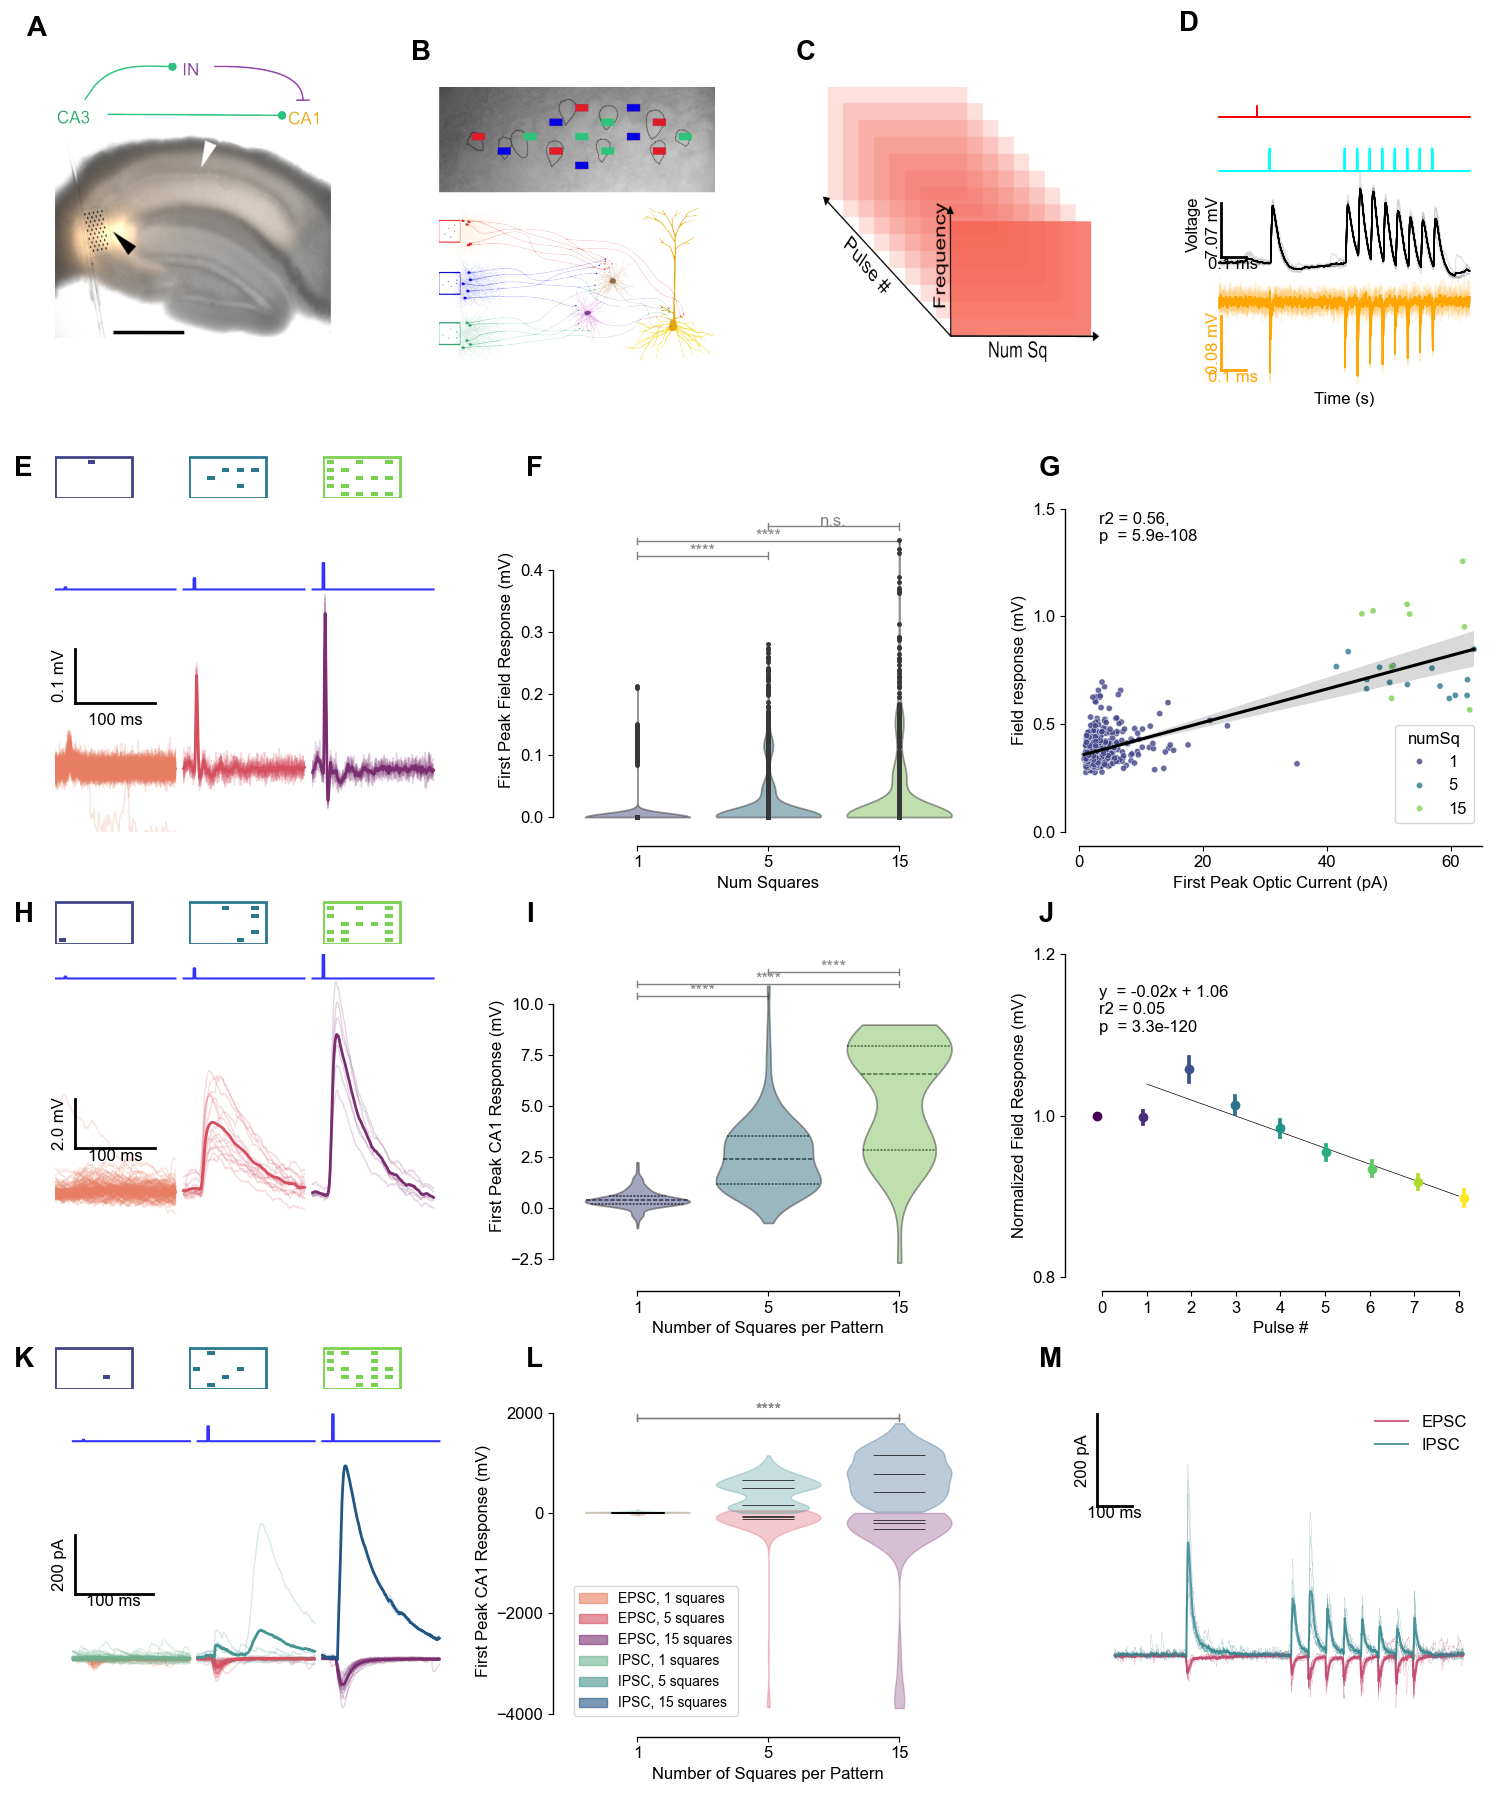

In [75]:
# Figure 1 initialization
plt.close('all')
# aspect ratio of the figure = 1
w, h = [15,18]
mosaic = '''
            AAABBBCCCDDD
            EEEEFFFFGGGG
            HHHHIIIIJJJJ
            KKKKLLLLMMMM
            '''
fig1, ax1 = plt.subplot_mosaic(mosaic, figsize=(w, h), )
ax1a, ax1b, ax1c, ax1d, ax1e, ax1f, ax1g, ax1h, ax1i, ax1j, ax1k, ax1l, ax1m = [ax1[_] for _ in ax1.keys()]

# have more space between suplots
fig1.subplots_adjust(hspace=0.5, wspace=0.5)

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Fig 1A: Slice, polygon projection, and recording electrodes
ax1a.text(-0.1, 1.1, 'A', transform=ax1a.transAxes, size=20, weight='bold')
image1_path = paper_figure_export_location / "Fig1A.png"
im1 = Image.open(image1_path)
imw, imh = im1.size
im1 = ax1a.imshow(im1, extent=[0, imw, 0, imh])
ax1a.set_aspect(imw/imh)
ax1a.axis('off')
ax1a.set_anchor('NW')

ax1b.text(-0.1, 1.1, 'B', transform=ax1b.transAxes, size=20, weight='bold')
image2_path = paper_figure_export_location / "Fig1B.png"
im2 = Image.open(image2_path)
imw, imh = im2.size
im2 = ax1b.imshow(im2, extent=[0, imw, 0, imh])
ax1b.set_aspect(imw/imh)
ax1b.axis('off')

ax1c.text(-0.1, 1.1, 'C', transform=ax1c.transAxes, size=20, weight='bold')
image3_path = paper_figure_export_location / "Fig1G.png"
im3 = Image.open(image3_path)
imw, imh = im3.size
im3 = ax1c.imshow(im3, extent=[0, imw, 0, imh])
ax1c.set_aspect(imw/imh)
ax1c.axis('off')

# # -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# # Fig 1D: Protocol Freq Sweep
ax1d.text(-0.1, 1.1, 'D', transform=ax1d.transAxes, size=20, weight='bold')
sample_cell = 1931  #screened_cc_cells[2] # 3131
celldata = xc_FS_longdf_slice[ (xc_FS_longdf_slice['clampMode']=='CC')& (xc_FS_longdf_slice['AP']==0) & (xc_FS_longdf_slice['numChannels']==4)]
data = celldata[(celldata['stimFreq']==20) & (celldata['numSq']==15)]
fig1, ax1d, signal_mapping = plot_tools.plot_data_from_df(data, data_start_column=49,combine=True, fig=fig1, ax=ax1d, )
scalebar_cell = signal_mapping['scalebar_cell']
scalebar_field = signal_mapping['scalebar_field']
# set legend inside the plot
ax1d.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9), frameon=True) # legend removed to save space
# simplify
plot_tools.simplify_axes(ax1d, splines_to_keep=[], )
# remove legend
ax1d.legend([],[], frameon=False)

# # -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# # # Fig 1E: Current clamp responses
ax1e.text(-0.1, 1.1, 'E', transform=ax1e.transAxes, size=20, weight='bold')
dftemp = xc_FS_longdf_slice[(xc_FS_longdf_slice['cellID']==4041) ]
ax1e.set_xlim([0, 0.5])
ax1e.set_ylim([-0.15, 0.45])
ax1e, ax1e_insets = plot_tools.draw_pulse_response_snippets(dftemp, ax1e, signal='field', window=0.15, patterns=range(56), between='clampPotential', hue='numSq', hues=[1,5,15],
                                                            grid_size=11,stim_scale=2.5, stim_offset=0.3 ,palette=color_squares_EI, invert=True, filter_data=True, passband=[100, 500])
ax1e.set_xticks([])
ax1e.set_yticks([])
# # axes spines to remove
# plot_tools.split_axes(ax1e, which_axes=['left', 'bottom'], offset=10)
sns.despine(ax=ax1e, top=True, right=True, left=True, bottom=True, offset=10, )
# add floating scalebar
plot_tools.add_floating_scalebar(ax1e, scalebar_origin=[0.05,0.4], xlength=0.1, ylength=0.1, labelx='100', labely='', unitx='ms', unity='mV', fontsize=12, color='black', linewidth=2, pad=0.01, show_labels=True)

# # -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# # # Fig 1F: CA3 cell_fpr vs field_fpr
ax1f.text(-0.1, 1.1, 'F', transform=ax1f.transAxes, size=20, weight='bold')
# plot a relationship between cell_fpr and field_fpr using a scatter plot (options: box, strip, swarm, violin, boxen)
dftemp1 = xc_FS_shortdf_slice[(xc_FS_shortdf_slice['numSq'].isin([1,5,15])) & (xc_FS_shortdf_slice['fieldunit']!='mV')]
# multiply field_fpr_p2p by 0.05 to get the correct scale
dftemp1['field_fpr_p2p'] = dftemp1['field_fpr_p2p']*0.05
dftemp2 = xc_FS_shortdf_slice[(xc_FS_shortdf_slice['numSq'].isin([1,5,15])) & (xc_FS_shortdf_slice['fieldunit']=='mV')]
#join the df back
dftemp = pd.concat([dftemp1, dftemp2], axis=0)
dftemp = dftemp.dropna(subset=['field_fpr_p2p'])

sns.violinplot(data=dftemp, x="numSq", y="field_fpr_p2p", hue="numSq", palette=color_squares, ax=ax1f, alpha=0.5, inner='point', split=False, dodge=False, cut=0, zorder=3)
[part.set_edgecolor((part.get_edgecolor()[:],  0)) for part in ax1f.get_children() if isinstance(part, mpl.collections.PolyCollection)]
print(dftemp2[dftemp2['clampMode']=='VC'].shape, dftemp2[dftemp2['clampMode']=='CC'].shape)
# # ax1f.set_ylabel('CA3 cell Response (mV)')
# # ax1f.set_xlabel('Number of Squares per Pattern')
# # no legend
ax1f.legend([],[], frameon=False)

# # remove top and right spines
ax1f.spines['top'].set_visible(False)
ax1f.spines['right'].set_visible(False)

# # statistics
importlib.reload(stat_annotate)
ax1f_pvalues, ax1f_nvalues = stat_annotate.pairwise_annotate_violin_plot(ax1f, dftemp, x='numSq', y='field_fpr_p2p', stat=mannwhitneyu, add_line=True, offset=0.15, color='grey',
                                                                        add_n=False, coord_system='', fontsize=12, zorder=10)

# set labels
ax1f.set_ylabel('First Peak Field Response (mV)')
ax1f.set_xlabel('Num Squares')
# legend off
ax1f.legend([],[], frameon=False)
# remove top and right spines
ax1f.spines['top'].set_visible(False)
ax1f.spines['right'].set_visible(False)
sns.despine(ax=ax1f, top=True, right=True, left=False, bottom=False, offset=10, trim=True) 

# #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# # # Fig 1G: CA3 cell_fpr vs field_fpr
ax1g.text(-0.1, 1.1, 'G', transform=ax1g.transAxes, size=20, weight='bold')
dftemp = xc_all_shortdf[ (xc_all_shortdf['cellID']==3161) ]
# # add scatterplot on ax1f
sns.scatterplot(data=dftemp, x="cell_fpr_max", y="field_fpr_p2p", hue='numSq', palette=color_squares, ax=ax1g, alpha=0.8, s=20, legend=True)
# add regression line to the scatterplot
sns.regplot(data=dftemp, x="cell_fpr_max", y="field_fpr_p2p", ax=ax1g, scatter=False, color='black', ci=95)
# calculate the correlation coefficient
resultsCA3 = linregress(dftemp["cell_fpr_max"], dftemp["field_fpr_p2p"])
# add r2 and p value to the plot as text annotation
ax1g.text(0.05, 0.9, f"r2 = {resultsCA3.rvalue**2:.2f}, \np  = {resultsCA3.pvalue:.2}", transform=ax1g.transAxes, fontsize=12)
ax1g.set_xlabel('First Peak Optic Current (pA)')
ax1g.set_ylabel('Field response (mV)')
# despine
ax1g.set_xlim([0, 65])
ax1g.set_xticks([0, 20, 40, 60,])
ax1g.set_yticks([0, 0.5, 1.0, 1.5])
sns.despine(ax=ax1g, top=True, right=True, left=False, bottom=False, offset=10, )

# # -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# # # Fig 1H: Current clamp responses
ax1h.text(-0.1, 1.1, 'H', transform=ax1h.transAxes, size=20, weight='bold')
ax1h.set_xlim([0, 0.5])
ax1h.set_ylim([-3.3, 10])
dftemp = xc_FS_longdf_slice[(xc_FS_longdf_slice['cellID']==4041)]
ax1h, ax1h_insets = plot_tools.draw_pulse_response_snippets(dftemp, ax1h, patterns=range(55), between='clampPotential', hue='numSq',  palette=color_squares_EI,grid_size=11,stim_offset=9, stim_scale=50,)
# # set ticks
ax1h.set_xticks([])
ax1h.set_yticks([])
# # axes spines to remove
sns.despine(ax=ax1h, top=True, right=True, left=True, bottom=True, offset=10, )
plot_tools.add_floating_scalebar(ax1h, scalebar_origin=[0.05,0.4], xlength=0.1, ylength=2.0, labelx='100', labely='', unitx='ms', unity='mV', fontsize=12, color='black', linewidth=2, pad=0.01, show_labels=True)

# # -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# # # Fig 1I: First peak response | cell_fpr_max vs numSq
ax1i.text(-0.1, 1.1, 'I', transform=ax1i.transAxes, size=20, weight='bold')
# # ax1g.set_title('First Peak Response')
dftemp = xc_FS_shortdf_slice[ (xc_FS_shortdf_slice['clampMode']=='CC') & (xc_FS_shortdf_slice['probePulseStart'] == 0.2) & (xc_FS_shortdf_slice['AP'] == 0)]
dftemp = dftemp.dropna(subset=['PSC_0'])
# # sns.stripplot(data=df_temp,  x="numSq", y="cell_fpr_max", hue="numSq", palette=color_squares, ax=ax1g, alpha=0.8, s=2, jitter=0.25, orient="v", linewidth=0.25)
sns.violinplot(data=dftemp, x="numSq", y="PSC_0", hue="numSq", palette=color_squares, ax=ax1i, alpha=0.5, inner='quart', split=False, dodge=False, cut=0, zorder=3)
[part.set_edgecolor((part.get_edgecolor()[:],  0)) for part in ax1i.get_children() if isinstance(part, mpl.collections.PolyCollection)]

ax1i.set_ylabel('First Peak CA1 Response (mV)')
ax1i.set_xlabel('Number of Squares per Pattern')
ax1i.legend([],[], frameon=False)
# remove top and right spines
ax1i.spines['top'].set_visible(False)
ax1i.spines['right'].set_visible(False)

# ## Statistics for the violin plots: mannwhitneyu Rank Sum Test across numSq values
ax1i_pvalues, ax1i_nvalues = stat_annotate.pairwise_annotate_violin_plot(ax1i, dftemp, x='numSq', y='PSC_0', stat=mannwhitneyu, add_line=True, offset=0.2, color='grey',
                                                                        add_n=False, coord_system='', fontsize=12, zorder=10)
sns.despine(ax=ax1i, top=True, right=True, left=False, bottom=False, offset=10, trim=True)   

# # -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# # # Fig 1J: Trend in the field response across pulses
ax1j.text(-0.1, 1.1, 'J', transform=ax1j.transAxes, size=20, weight='bold')
dftemp = xc_FS_shortdf_slice[(xc_FS_shortdf_slice['numSq'].isin([1,5,15])) & (xc_FS_shortdf_slice['numChannels']==4)]
dftemp = dftemp.reset_index(drop=True)
# explode 'peaks_field' column to get a 9 columns for 9 pulses for each row
dfx = pd.DataFrame(columns=['pulse_index'])
for i in range(len(dftemp)):
    x = np.array(range(9), dtype='object')
    dfx.at[i, 'pulse_index'] = x
# concetnate the two dataframes
dftemp = pd.concat([dftemp, dfx], axis=1)
dftemp = dftemp.explode(['peaks_field_norm','pulse_index'])
# # convert 'peaks_field_norm' and 'pulse_index' to float
dftemp['peaks_field_norm'] = dftemp['peaks_field_norm'].astype(float)
dftemp['pulse_index'] = dftemp['pulse_index'].astype(int)

dftemp = dftemp.reset_index(drop=True)
dftemp = dftemp.dropna(subset=['peaks_field_norm', 'pulse_index'])
# # draw pointplot
sns.pointplot(data=dftemp, x='pulse_index', y='peaks_field_norm', hue='pulse_index', markersize=5, palette='viridis', dodge=True, ax=ax1j, errorbar=('ci', 95), zorder=3)

# # remove 0th pulse data for the regression to avoide the bias
dftemp = dftemp[dftemp['pulse_index']!=0]
results = linregress(dftemp['pulse_index'], dftemp['peaks_field_norm'])
# # add r2 and p value to the plot as text annotation
ax1j.text(0.05, 0.76, f"y  = {results.slope:.2f}x + {results.intercept:.2f} \nr2 = {results.rvalue**2:.2f} \np  = {results.pvalue:.2}", transform=ax1j.transAxes, fontsize=12)
# # set labels
ax1j.set_ylabel('Normalized Field Response (mV)')
ax1j.set_xlabel('Pulse #')
ax1j.plot([1,8], [results.intercept + results.slope, results.intercept + results.slope*8], color='black', linestyle='-', linewidth=0.5)
ax1j.set_ylim([0.8,1.2])
ax1j.set_yticks([0.8,1.0,1.2])
ax1j.legend([],[], frameon=False)
# # despine
sns.despine(ax=ax1j, top=True, right=True, left=False, bottom=False, offset=10, trim=True)

# # -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# # # Fig 1K: Trend in the field response across pulses
ax1k.text(-0.1, 1.1, 'K', transform=ax1k.transAxes, size=20, weight='bold')
# ax1k.set_xlim([0, 0.5])
# ax1k.set_ylim([-400,1200])
dftemp = xc_FS_longdf_slice[(xc_FS_longdf_slice['cellID']==6201)]
print( dftemp['clampPotential'].unique())
ax1k, ax1j_insets = plot_tools.draw_pulse_response_snippets(dftemp, ax1k, patterns=range(55), palette=color_squares_EI, between='clampPotential', hue='numSq',stim_offset=750, stim_scale=200, grid_size=11)
# set ticks
ax1k.set_xticks([])
ax1k.set_yticks([])
# axes spines to remove
# plot_tools.split_axes(ax1k, which_axes=['left', 'bottom'], offset=10)
sns.despine(ax=ax1k, top=True, right=True, left=True, bottom=True, offset=10, )
plot_tools.add_floating_scalebar(ax1k, scalebar_origin=[0.05,0.4], xlength=0.1, ylength=200, labelx='100', labely='', unitx='ms', unity='pA', fontsize=12, color='black', linewidth=2, pad=0.01, show_labels=True)

# # -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# # # Fig 1l: Trend in the field response across pulses
ax1l.text(-0.1, 1.1, 'L', transform=ax1l.transAxes, size=20, weight='bold')
dftemp = xc_FS_shortdf_slice[ (xc_FS_shortdf_slice['clampMode']=='VC') & (xc_FS_shortdf_slice['probePulseStart'] == 0.2)]
dftemp = dftemp.dropna(subset=['PSC_0'])
pscdict = {-70: [], 0: []}
for k,v in pscdict.items():
    for sq in [1,5,15]:
        dftemp1 = dftemp[(dftemp['clampPotential']==k) & (dftemp['numSq']==sq)]
        sqlist = dftemp1['PSC_0'].to_list()
        pscdict[k].append(sqlist)
labels=[]
for clamp in [-70,0]:
    side = 'low' if clamp == 0 else 'high'
    P ='EPSC' if clamp == -70 else 'IPSC'
    parts = ax1l.violinplot(pscdict[clamp], positions=[1,2,3], vert=True, widths=0.8, showmeans=False,
                          showextrema=False, quantiles=[[0.25,0.75],[0.25,0.75],[0.25,0.75]] ,showmedians=True, side='both', )
    a,b,c = pscdict[clamp]
    _, pval = kruskal(a,b,c)
    stat_annotate.annotate_stat_stars(ax1l, pval, alpha=0.05, star_loc=[2,1950], add_line=True, line_locs=[1,3,1900,1900],
                                        offset_btw_star_n_line=0.1, color='grey', coord_system='data',)
    for s, violin in enumerate(parts['bodies']):
        sq = [1,5,15][s]
        color = color_squares_EI[clamp][sq]
        color = mpl.colors.to_rgba(color, alpha=0.6)
        violin.set_facecolor(color)
        violin.set_edgecolor(color)
        labels.append((mpatches.Patch(color=color), f'{P}, {sq} squares'))
    for partname in ['cquantiles','cmedians',]:
        vp = parts[partname]
        vp.set_edgecolor('black')
        vp.set_linewidth(0.5)

ax1l.set_ylabel('First Peak CA1 Response (mV)')
ax1l.set_xlabel('Number of Squares per Pattern')
ax1l.legend(*zip(*labels), loc='lower left', bbox_to_anchor=(0,0), frameon=True, ncols=1, fontsize=10)
# remove top and right spines
ax1l.spines['top'].set_visible(False)
ax1l.spines['right'].set_visible(False)
# set ticklabels
ax1l.set_xticks([1,2,3])
ax1l.set_xticklabels(['1','5','15'])
# set yticks
ax1l.set_yticks([-4000,-2000, 0,2000])
sns.despine(ax=ax1l, top=True, right=True, left=False, bottom=False, offset=10, trim=True)  

# # -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# # # Fig 1m: Trend in the field response across pulses
ax1m.text(-0.1, 1.1, 'M', transform=ax1m.transAxes, size=20, weight='bold')
sample_cell = 111  #screened_vc_cells[2] # 111, 7492, 1621
celldataE = xc_FS_longdf_slice[ (xc_FS_longdf_slice['clampMode']=='VC') & (xc_FS_longdf_slice['cellID']==sample_cell) & (xc_FS_longdf_slice['clampPotential']==-70) & (xc_FS_longdf_slice['stimFreq']==20) & (xc_FS_longdf_slice['numSq']==15)]
celldataI = xc_FS_longdf_slice[ (xc_FS_longdf_slice['clampMode']=='VC') & (xc_FS_longdf_slice['cellID']==sample_cell) & (xc_FS_longdf_slice['clampPotential']==  0) & (xc_FS_longdf_slice['stimFreq']==20) & (xc_FS_longdf_slice['numSq']==15)]
time = np.linspace(0,1,20000)
for i in range(celldataE.shape[0]):
    ax1m.plot(time, celldataE.iloc[i,49:20049], color=color_EI[-70], linewidth=0.2, alpha=0.5)
    ax1m.plot(time, celldataI.iloc[i,49:20049], color=color_EI[0], linewidth=0.2, alpha=0.5)
# plot mean
ax1m.plot(time, celldataE.iloc[:,49:20049].mean(axis=0), color=color_EI[-70], linewidth=1.5, alpha=0.8, label='EPSC')
ax1m.plot(time, celldataI.iloc[:,49:20049].mean(axis=0), color=color_EI[0], linewidth=1.5, alpha=0.8, label='IPSC')
# set legend inside the plot
ax1m.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9), frameon=True) # legend removed to save space
# remove legend
ax1m.legend(loc='upper right', frameon=False)
# add a floating scalebar
sns.despine(ax=ax1m, left=True, right=True, top=True, bottom=True)
# remove ticks
ax1m.set_xticks([])
ax1m.set_yticks([])
plot_tools.add_floating_scalebar(ax1m, scalebar_origin=[0.0,0.8], xlength=0.1, ylength=200, labelx='100', labely='200', unitx='ms', unity='pA', fontsize=12, color='black', linewidth=2, pad=0.02, show_labels=True)
# # -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
for ax in [ax1a, ax1b, ax1c, ax1d, ax1e, ax1f, ax1g, ax1h, ax1i, ax1j, ax1k, ax1l, ax1m]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)

for ax in [ax1a, ax1b, ax1c, ax1d, ax1e, ax1f, ax1g, ax1h, ax1i, ax1j, ax1k, ax1l, ax1m]:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1)

# # -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# tight layout
plt.tight_layout()
# # save figure
figure_name = 'Figure1'
fig1.savefig(paper_figure_export_location /  (figure_name + '.png'), dpi=300, bbox_inches='tight')
fig1.savefig(paper_figure_export_location /  (figure_name + '.svg'), dpi=300, bbox_inches='tight')


In [69]:
xc_FS_longdf_slice[(xc_FS_longdf_slice['clampMode']=='CC')]['cellID'].unique()

array([4041, 3611, 3131, 5611, 5291, 5212, 5211, 3881, 3882, 3872, 3871,
       3791, 3781, 3402, 3401, 2501])

[-70   0]
##
 Assessing dataframe: 
Total clampPotential_patternList combined: 6
Total Trials: 39
Data Size: (39, 80073) 
 clampPotential  patternList
-70             52             12
                53             12
                55             12
 0              52              1
                53              1
                55              1
Name: trialID, dtype: int64
[15, 15, 15]
plotting 52 and -70
(12, 80073)
plotting 52 and 0
(1, 80073)
52 15 [101, 109, 117, 147, 155, 197, 305, 309, 339, 343, 351, 401, 451, 485, 497]
plotting 53 and -70
(12, 80073)
plotting 53 and 0
(1, 80073)
53 15 [151, 163, 197, 201, 209, 213, 259, 301, 339, 347, 393, 401, 435, 439, 489]
plotting 55 and -70
(12, 80073)
plotting 55 and 0
(1, 80073)
55 15 [105, 151, 163, 201, 213, 247, 259, 293, 297, 389, 397, 435, 489, 493, 501]
[-70]
##
 Assessing dataframe: 
Total clampPotential_patternList combined: 3
Total Trials: 9
Data Size: (9, 80073) 
 clampPotential  patternList
-70             52            

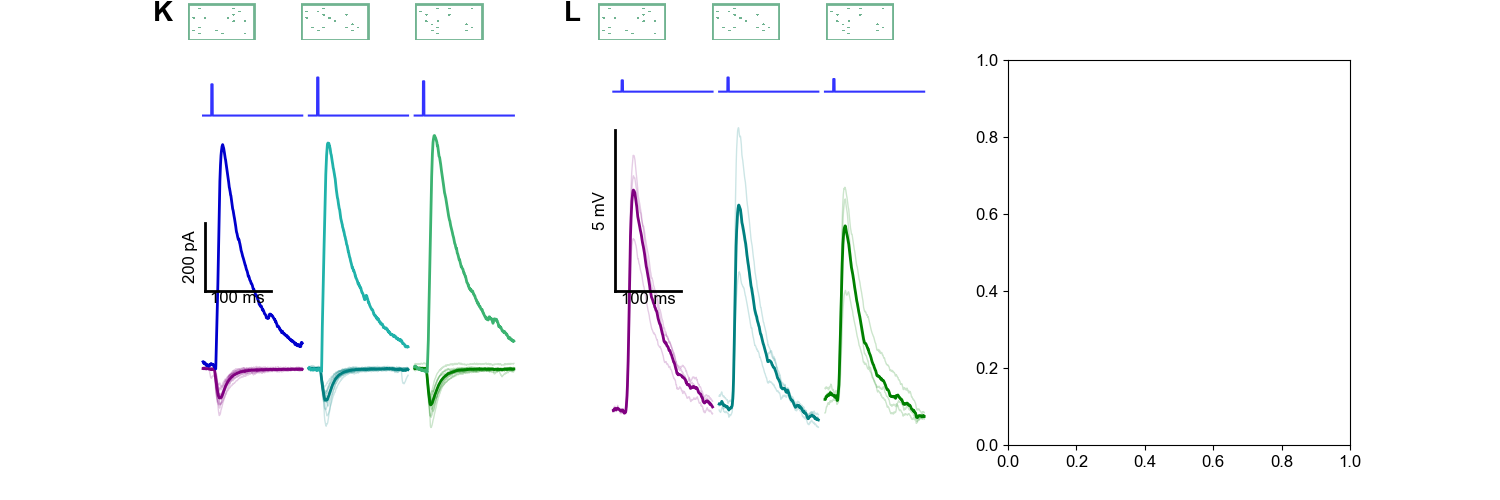

In [72]:
fig, [ax1s1, ax1s2, ax1s3] = plt.subplots(1,3, figsize=(15,5))
# # -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
importlib.reload(plot_tools)
# # # Fig 1K: Trend in the field response across pulses
ax1s1.text(-0.1, 1.1, 'K', transform=ax1s1.transAxes, size=20, weight='bold')
# ax1s1.set_xlim([0, 0.5])
# ax1s1.set_ylim([-400,1200])
dftemp = xc_FS_longdf_slice[(xc_FS_longdf_slice['cellID']==6201)&(xc_FS_longdf_slice['numSq']==15)]
print( dftemp['clampPotential'].unique())
utils.get_cellwise_numtrials(dftemp, ['clampPotential', 'patternList'])
ax1s1, ax1j_insets = plot_tools.draw_pulse_response_snippets(dftemp, ax1s1, draw_listed_pattern=True, patterns=[52,53,55], between='clampPotential', hue='patternList', hues=[52,53,55],
                                                            stim_offset=0.8, stim_scale=200, grid_size=24, 
                                                            palette={-70:{52:'purple',53:'teal',55:'green'}, 0:{52:'mediumblue',53:'lightseagreen',55:'mediumseagreen'}})
# set ticks
ax1s1.set_xticks([])
ax1s1.set_yticks([])
# axes spines to remove
# plot_tools.split_axes(ax1s1, which_axes=['left', 'bottom'], offset=10)
sns.despine(ax=ax1s1, top=True, right=True, left=True, bottom=True, offset=10, )
plot_tools.add_floating_scalebar(ax1s1, scalebar_origin=[0.05,0.4], xlength=0.1, ylength=200, labelx='100', labely='', unitx='ms', unity='pA', fontsize=12, color='black', linewidth=2, pad=0.01, show_labels=True)

ax1s2.text(-0.1, 1.1, 'L', transform=ax1s2.transAxes, size=20, weight='bold')
# ax1s2.set_xlim([0, 0.5])
# ax1s2.set_ylim([-400,1200])
dftemp = xc_FS_longdf_slice[(xc_FS_longdf_slice['cellID']==4041)&(xc_FS_longdf_slice['numSq']==15)]
print( dftemp['clampPotential'].unique())
utils.get_cellwise_numtrials(dftemp, ['clampPotential', 'patternList'])
ax1s2, ax1j_insets = plot_tools.draw_pulse_response_snippets(dftemp, ax1s2, draw_listed_pattern=True, patterns=[52,53,55], between='clampPotential', hue='patternList', hues=[52,53,55],stim_offset=10, stim_scale=20, grid_size=24, palette={-70:{52:'purple',53:'teal',55:'green'}, 0:{52:'mediumblue',53:'lightseagreen',55:'mediumseagreen'}})
# set ticks
ax1s2.set_xticks([])
ax1s2.set_yticks([])
# axes spines to remove
# plot_tools.split_axes(ax1s2, which_axes=['left', 'bottom'], offset=10)
sns.despine(ax=ax1s2, top=True, right=True, left=True, bottom=True, offset=10, )
plot_tools.add_floating_scalebar(ax1s2, scalebar_origin=[0.05,0.4], xlength=0.1, ylength=5, labelx='100', labely='', unitx='ms', unity='mV', fontsize=12, color='black', linewidth=2, pad=0.01, show_labels=True)

## Generate image composites separately for high res

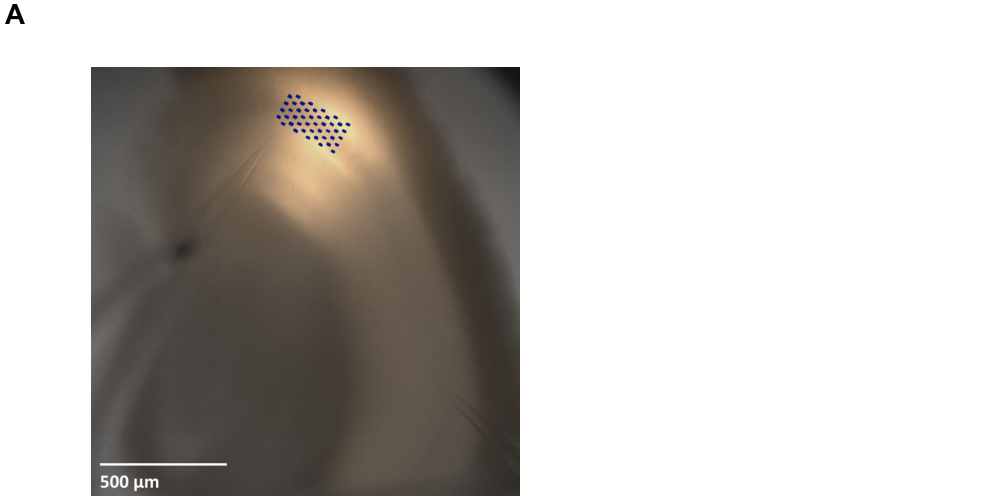

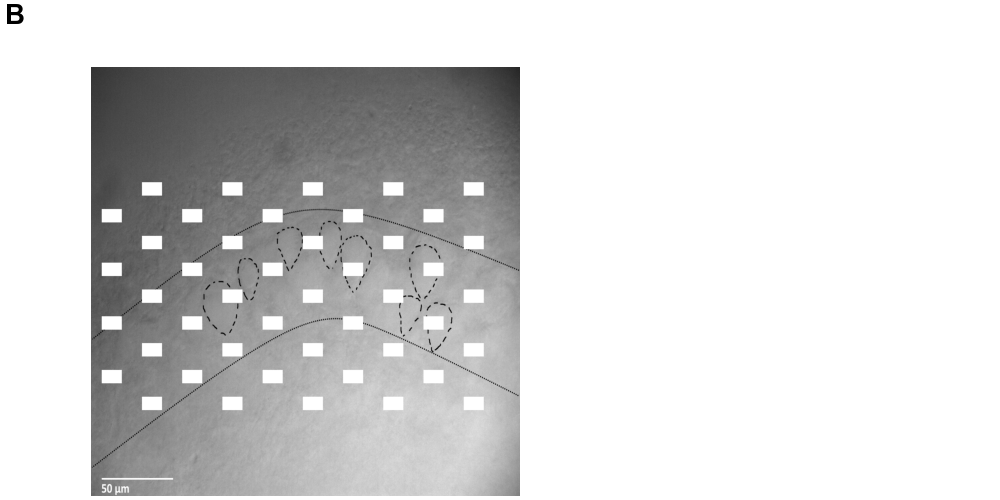

In [10]:
Fig1A_hr, ax1A_hr = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)

# Fig 1A: Slice, polygon projection, and recording electrodes
ax1A_hr.text(-0.1, 1.1, 'A', transform=ax1A_hr.transAxes, size=20, weight='bold')
image1_path = all_cells.project_path_root / r"Lab\Projects\EI_Dynamics\Analysis\paper_figure_matter\slice_electrode_expression_cropped_with_scalebar_blue_polygon.png"
im1 = Image.open(image1_path)
# get the size of the image
im1_width, im1_height = im1.size
# get the aspect ratio of the ax1A_hr axes object
ax1a_ratio = ax1A_hr.get_window_extent().width / ax1A_hr.get_window_extent().height

# change the axis limits so that verticle side of the image fits the axis and horizontal side is aligned left on the axis
ax1A_hr.set_ylim(0, im1_height)
ax1A_hr.set_xlim(0, im1_height*ax1a_ratio)
# plot the image
ax1A_hr.imshow(im1, extent=[0, im1_width, 0, im1_height], aspect=1)
ax1A_hr.axis('off')

# # save figure
figure_name = 'Figure1A_highres'
Fig1A_hr.savefig(paper_figure_export_location /  (figure_name + '.png'), dpi=300, bbox_inches='tight')
Fig1A_hr.savefig(paper_figure_export_location /  (figure_name + '.svg'), dpi=300, bbox_inches='tight')
# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Fig 1B: Grid Pattern in Space overlaid on CA3 slice at 40x
Fig1B_hr, ax1B_hr = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
ax1B_hr.text(-0.1, 1.1, 'B', transform=ax1B_hr.transAxes, size=20, weight='bold')
image2_path = all_cells.project_path_root / r'Lab\Projects\EI_Dynamics\Analysis\paper_figure_matter\CA3-polygonFrame_figure_with_cellboundaries.png'
im2 = Image.open(image2_path)
im2_width, im2_height = im2.size
# ax1B_hr.imshow(im2)

ax1B_hr.set_ylim(0, im1_height)
ax1B_hr.set_xlim(0, im1_height*ax1a_ratio)
ax1B_hr.imshow(im2, extent=[0, im1_width, 0, im1_height], aspect=1)
ax1B_hr.axis('off')
# ax1B_hr.set_anchor('W')

# # save figure
figure_name = 'Figure1B_highres'
Fig1B_hr.savefig(paper_figure_export_location /  (figure_name + '.png'), dpi=300, bbox_inches='tight')
Fig1B_hr.savefig(paper_figure_export_location /  (figure_name + '.svg'), dpi=300, bbox_inches='tight')


### Supplementary Figure 1: CA3 heatmap

AssertionError: spot_locs and spot_values must be the same length

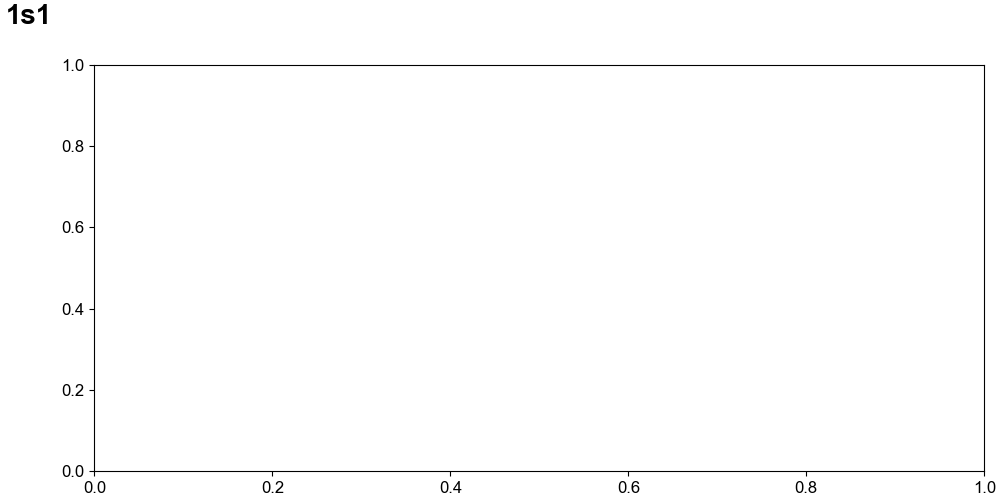

In [11]:
Fig1s1, ax1s1 = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
ax1s1.text(-0.1, 1.1, '1s1', transform=ax1s1.transAxes, size=20, weight='bold')
# import heatmap data
df_CA3_heatmap = pd.read_hdf(r"parsed_data\second_order\CA3_recording_3161_grid_response_pivot.h5")

grid_aspect_ratio = pattern_index.polygon_frame_properties['aspect_ratio']

h = 8
w = grid_aspect_ratio*h
# ax1s1.suptitle('Peak Response to 9 pulses in 24 hexagonal grid squares', fontsize=16)

pulse = 0
# get data from column=i and all rows
vals = df_CA3_heatmap[pulse].values
# get index values
idx = (df_CA3_heatmap[pulse].index.get_level_values(0).values) - 1

# make heatmaps
_,_,ax1s1,_ = plot_tools.plot_grid(spot_locs=idx, spot_values=vals, grid=[24,24], cmap='viridis', ax=ax1s1, vmin=0, vmax=15, add_colorbar=False)
# set xlim and ylim to be 0, 24
ax1s1.set_xlim([0, 24])
ax1s1.set_ylim([0, 24])
# add colorbar to the axis correponding the heatmap image
cbar = plt.colorbar(ax1s1.get_children()[1], ax=ax1s1, orientation='vertical', pad=0.01)
cbar.set_label('Optical Depolarization (pA)', rotation=270, labelpad=10)
# set limit
# cbar.set_zlim([0, 15])
# set ticks
cbar.set_ticks([0, 5, 10, 15])
cbar.ax.tick_params(labelsize=12)
# add text to the plot on top left corner of the heatmap in white color
ax1s1.text(0.0, 0.9, 'Basal', transform=ax1s1.transAxes, size=12,  color='white')
# add text to the plot on bottom left corner of the heatmap
ax1s1.text(0.0, 0.05, 'Apical', transform=ax1s1.transAxes, size=12, color='white')
ax1s1.set_title('CA3 Response to grid spots')

# make a horizontal line to show scale
ax1s1.plot([1, 3], [4, 4], color='white', linewidth=2)
ax1s1.plot([1, 1], [4, 6], color='white', linewidth=2)
ax1s1.text(1.5, 2.5, '26 $\mu$m', color='white', fontsize=12)


# save figure
figure_name = 'Figure1s1_CA3heatmap'
Fig1s1.savefig(paper_figure_export_location /  (figure_name + '.png'), dpi=300, bbox_inches='tight')
Fig1s1.savefig(paper_figure_export_location /  (figure_name + '.svg'), dpi=300, bbox_inches='tight')

### Supplmentary Figure 2: CA3 response to grid stim vs numSq

C:\Users\adity\AppData\Local\Temp\ipykernel_83800\3231224260.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cell_fpr_max'] = np.where(df_temp['cell_fpr_max']>15, 25, df_temp['cell_fpr_max'])
C:\Users\adity\AppData\Local\Temp\ipykernel_83800\3231224260.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
C:\Users\adity\AppData\Local\Temp\ipykernel_83800\3231224260.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


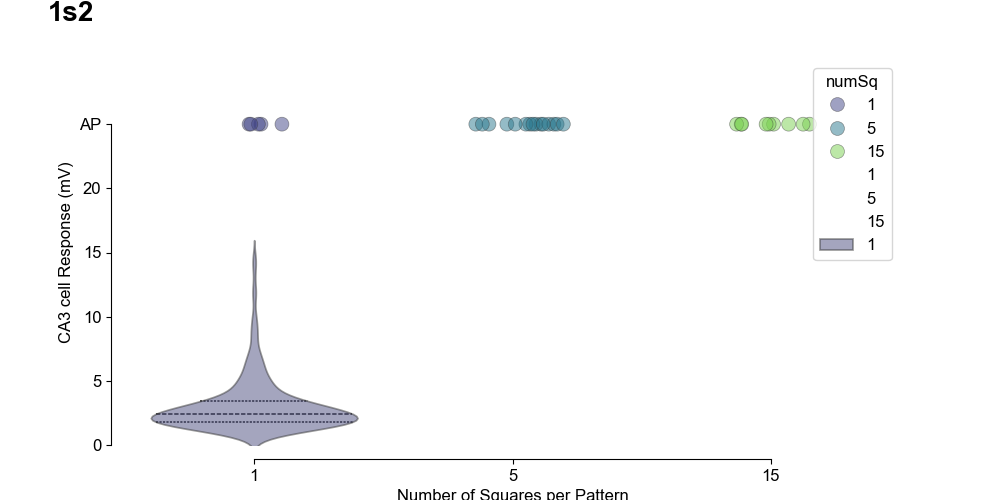

: 

: 

In [13]:
# # Fig 1s2: CA3 pulse response
Fig1s2, ax1s2 = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
ax1s2.text(-0.1, 1.1, '1s2', transform=ax1s2.transAxes, size=20, weight='bold')
df_temp = xc_all_shortdf[ (xc_all_shortdf['cellID']==3161) ]
df_temp2 = df_temp.copy()
# if the cell_fpr_max is greater than 15, make it 100
df_temp['cell_fpr_max'] = np.where(df_temp['cell_fpr_max']>15, 25, df_temp['cell_fpr_max'])
# plot a relationship between cell_fpr and field_fpr using a scatter plot (options: box, strip, swarm, violin, boxen)
sns.stripplot(data=df_temp[df_temp['cell_fpr_max']>15], y="cell_fpr_max",  x='numSq', jitter=0.2, ax=ax1s2, hue='numSq', palette=color_squares, linewidth=0.5, size=10, alpha=0.5, zorder=5)
sns.violinplot(data=df_temp2, x="numSq", y="cell_fpr_max", hue="numSq", palette=color_squares, ax=ax1s2, alpha=0.0, inner=None, split=False, dodge=False, zorder=3)
[part.set_edgecolor((part.get_edgecolor()[:],  0)) for part in ax1s2.get_children() if isinstance(part, mpl.collections.PolyCollection)]
stat_annotate.pairwise_annotate_violin_plot(ax1s2, df_temp, x='numSq', y='cell_fpr_max', stat=mannwhitneyu, add_line=True, offset=0.2, color='grey', coord_system='data', fontsize=12, zorder=10)

sns.violinplot(data=df_temp[df_temp['cell_fpr_max']<15], x="numSq", y="cell_fpr_max", hue="numSq", palette=color_squares, ax=ax1s2, alpha=0.5, inner='quart', split=False, dodge=False, zorder=3)
ax1s2.set_ylabel('CA3 cell Response (mV)')
ax1s2.set_xlabel('Number of Squares per Pattern')
ax1s2.set_ylim([0, 30])
yticks = [0, 5, 10, 15, 20, 25]
yticklabels = [0, 5, 10, 15, 20, 'AP']
ax1s2.set_yticks(yticks)
ax1s2.set_yticklabels(yticklabels)
# despine
sns.despine(ax=ax1s2, top=True, right=True, left=False, bottom=False, offset=10, trim=True)
# tight layout
plt.tight_layout()

# save figure
figure_name = 'Figure1s2_CA3cellfpr'
Fig1s2.savefig(paper_figure_export_location /  (figure_name + '.png'), dpi=300, bbox_inches='tight')
Fig1s2.savefig(paper_figure_export_location /  (figure_name + '.svg'), dpi=300, bbox_inches='tight')

### Supplementary Figure 3: PPR and STPR vs fpr across stimfreq

C:\Users\adity\AppData\Local\Temp\ipykernel_83800\3162380607.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in leg.legendHandles:


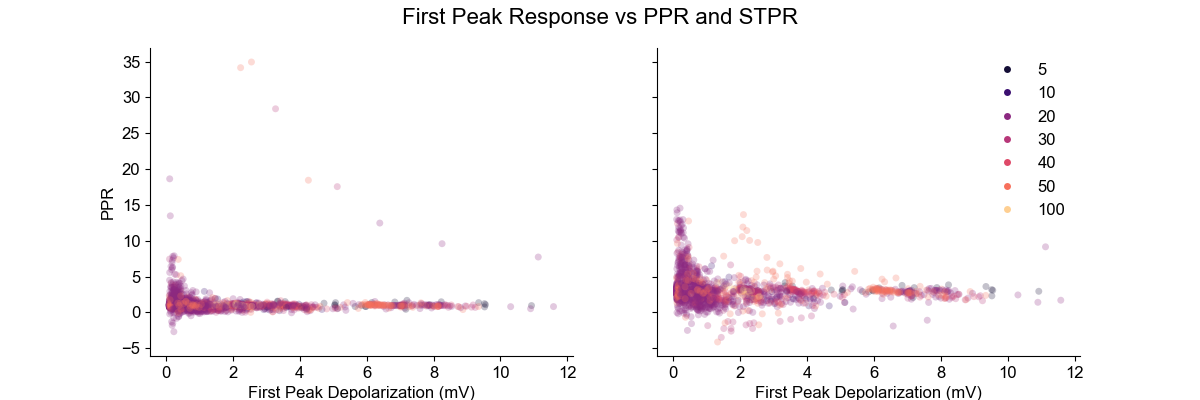

: 

: 

In [14]:
# # Fig 1s3: First pulse response vs ppr and stpr
fig1s3, ax1s3 = plt.subplots(1,2, figsize=(12,4), sharey=True)
# figure supertitle
fig1s3.suptitle('First Peak Response vs PPR and STPR', fontsize=16)
# if 
df_temp = xc_all_shortdf[  (xc_all_shortdf['probePulseStart']==0.2) & (xc_all_shortdf['clampMode']=='CC') & (xc_all_shortdf['cell_stpr']<15) & (xc_all_shortdf['cell_fpr']>0.1) & (xc_all_shortdf['cell_fpr']<20) & (xc_all_shortdf['protocol']=='FreqSweep') ] #& (xc_all_shortdf['field_fpr']<10)
# if 'cell_fpr' is greater than 120, divide it by 20
# df_temp['cell_fpr'] = np.where(df_temp['cell_fpr']>120, df_temp['cell_fpr']/20, df_temp['cell_fpr'])


sns.scatterplot(data=df_temp, x="cell_fpr", y="cell_ppr", hue='stimFreq', palette=color_freq, ax=ax1s3[0], alpha=0.25, s=25, legend=True, linewidth=0)
ax1s3[0].set_xlabel('First Peak Depolarization (mV)')
ax1s3[0].set_ylabel('PPR')
# legend off
ax1s3[0].legend([],[], frameon=False)
# remove top and right spines
ax1s3[0].spines['top'].set_visible(False)
ax1s3[0].spines['right'].set_visible(False)

sns.scatterplot(data=df_temp, x="cell_fpr", y="cell_stpr", hue='stimFreq', palette=color_freq, ax=ax1s3[1], alpha=0.25, s=25, legend=True, linewidth=0)
ax1s3[1].set_xlabel('First Peak Depolarization (mV)')
ax1s3[1].set_ylabel('STPR')

leg = ax1s3[1].legend(frameon=False,)
# Change the facecolor alpha of legend symbols
for handle in leg.legendHandles:
    handle.set_alpha(1.0)

# remove top and right spines
ax1s3[1].spines['top'].set_visible(False)
ax1s3[1].spines['right'].set_visible(False)

# save fig
figure_name = 'Figure1s3'
fig1s3.savefig(paper_figure_export_location / (figure_name + '.png'), dpi=300, bbox_inches='tight')
fig1s3.savefig(paper_figure_export_location / (figure_name + '.svg'), dpi=300, bbox_inches='tight')


### Supplementary Figure 4: PPR and STPR vs fpr across numSq

C:\Users\adity\AppData\Local\Temp\ipykernel_83800\2125124682.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in leg.legendHandles:


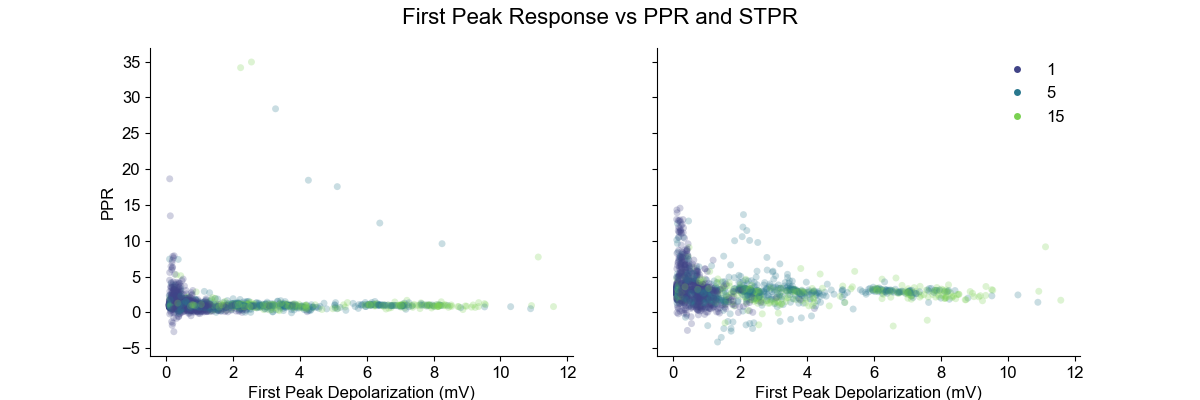

: 

: 

In [15]:
# # Fig 1s3: First pulse response vs ppr and stpr
fig1s4, ax1s4 = plt.subplots(1,2, figsize=(12,4), sharey=True)
# figure supertitle
fig1s4.suptitle('First Peak Response vs PPR and STPR', fontsize=16)
# if 
df_temp = xc_all_shortdf[ (xc_all_shortdf['probePulseStart']==0.2) & (xc_all_shortdf['clampMode']=='CC') & (xc_all_shortdf['cell_stpr']<15) & (xc_all_shortdf['cell_fpr']>0.1) & (xc_all_shortdf['cell_fpr']<20) & (xc_all_shortdf['protocol']=='FreqSweep') ] #& (xc_all_shortdf['field_fpr']<10)
# if 'cell_fpr' is greater than 120, divide it by 20
# df_temp['cell_fpr'] = np.where(df_temp['cell_fpr']>120, df_temp['cell_fpr']/20, df_temp['cell_fpr'])


sns.scatterplot(data=df_temp, x="cell_fpr", y="cell_ppr", hue='numSq', palette=color_squares, ax=ax1s4[0], alpha=0.25, s=25, legend=True, linewidth=0)
ax1s4[0].set_xlabel('First Peak Depolarization (mV)')
ax1s4[0].set_ylabel('PPR')
# legend off
ax1s4[0].legend([],[], frameon=False)
# remove top and right spines
ax1s4[0].spines['top'].set_visible(False)
ax1s4[0].spines['right'].set_visible(False)

sns.scatterplot(data=df_temp, x="cell_fpr", y="cell_stpr", hue='numSq', palette=color_squares, ax=ax1s4[1], alpha=0.25, s=25, legend=True, linewidth=0)
ax1s4[1].set_xlabel('First Peak Depolarization (mV)')
ax1s4[1].set_ylabel('STPR')

leg = ax1s4[1].legend(frameon=False,)
# Change the facecolor alpha of legend symbols
for handle in leg.legendHandles:
    handle.set_alpha(1.0)

# remove top and right spines
ax1s4[1].spines['top'].set_visible(False)
ax1s4[1].spines['right'].set_visible(False)

# save fig
figure_name = 'Figure1s4'
fig1s4.savefig(paper_figure_export_location / (figure_name + '.png'), dpi=300, bbox_inches='tight')
fig1s4.savefig(paper_figure_export_location / (figure_name + '.svg'), dpi=300, bbox_inches='tight')


### Fig1s2

In [16]:
# 1. Desensitization from within a CA3 cell: Over 8-9 pulses for each grid square, plot the line diagram of normalized response vs pulse index (1 cell, lots of grid points)
# 2. Desensitization from CA3 cell layer: plot across pulses, normazlied field response for 1sq, 5sq, 15sq data vs pulse index
# 3. To show optical stimulation: plot CA3 AP on a grid and depolarization on the grid (less data, only 1 cell)

: 

: 

In [17]:
# Fig E: numSq vs 'cell_fpr'
# 1. combine the grid and freqsweep data
# 2. make two subplots, first for AP, second for subthreshold responses
# 3. Plot response vs numSq

freq_sweep_cc_datapath =  r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\all_cells_FreqSweep_CC_long.h5" 
df = pd.read_hdf(freq_sweep_cc_datapath, key='data')
df = df[df['cellID']==3161]
print(df.shape)
# grid dataframe
grid_datapath =  r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\all_cells_grid_CC_long.h5" 
df2 = pd.read_hdf(grid_datapath, key='data')
print(df2.shape)
df2 = df2[df2['cellID']==3161]
print(df2.shape)

# concatenate the two dataframes
df3 = pd.concat([df, df2])

FileNotFoundError: File C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\all_cells_FreqSweep_CC_long.h5 does not exist

: 

: 

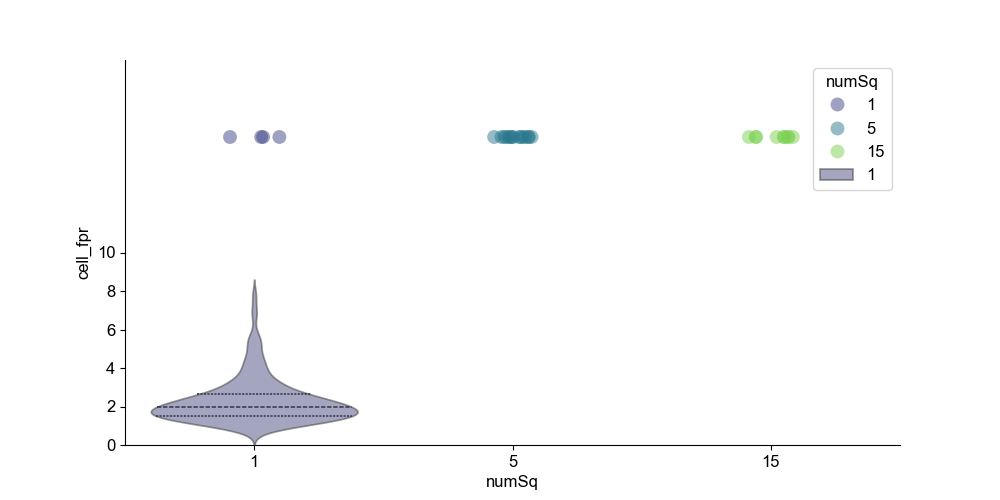

: 

: 

In [4]:
df3['cell_fpr'] = df3.apply(lambda x: x[4049:4249].max(), axis=1)
# if cell_fpr is greater than threshold mV, then it is an AP, else it is a subthreshold response
threshold = 8
df3['AP'] = df3['cell_fpr'] > threshold
# if 'cell_fpr' is greater than threshold, then cell_fpr = threshold*2, else cell_fpr = cell_fpr
df3['cell_fpr'] = df3.apply(lambda x: threshold*2 if x['AP'] else x['cell_fpr'], axis=1)
figE, axE = plt.subplots(1,1, figsize=(10,5))
# plot the subthreshold data
sns.stripplot(data=df3[df3['AP']==True], x="numSq", y='cell_fpr', hue="numSq", size=10, palette=color_squares, ax=axE, alpha=0.5, zorder=5)
sns.violinplot(data=df3[df3['AP']==False], x="numSq", y="cell_fpr", hue="numSq", palette=color_squares, ax=axE, alpha=0.5, inner='quart', split=False, dodge=False, zorder=3)
[part.set_edgecolor((part.get_edgecolor()[:],  0)) for part in axE.get_children() if isinstance(part, mpl.collections.PolyCollection)]

# keep yticks on from 0 to 10
axE.set_ylim(0, 20)
axE.set_yticks(np.arange(0, 11, 2))

# remove spines
axE.spines['top'].set_visible(False)
axE.spines['right'].set_visible(False)

# save it as a figure
figure_name = 'Figure1E'
# figE.savefig(paper_figure_export_location /  (figure_name + '.png'), dpi=300, bbox_inches='tight')
# figE.savefig(paper_figure_export_location /  (figure_name + '.svg'), dpi=300, bbox_inches='tight')
